In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 09b
## Introduction to Pytorch
- one hidden layer 
- ${tanh}$ activation function
- multi-class output
- FIFA dataset 

<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
import os
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

2024-07-14 12:37:52.230479: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 12:37:52.242537: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 12:37:52.246197: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-14 12:37:52.255988: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-14 12:37:53.062337: W tensorflow/compiler/tf2

In [3]:
# Some basic parameters
inpDir = '../../input'
outDir = '../output'
modelDir = '../models'
modelSubDir = 'pytorch_fifa'

RANDOM_STATE = 24
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 101 # number of epochs
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2
BATCH_SIZE = 32

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.Spectral

plt.rcParams.update(params)

## Helper Function
* Import from util.helper

## Read FIFA 2019 data set
<img src = '../../images/fifa_2019.png' alt = 'Fifa 2019'>

In [4]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [5]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [6]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [7]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [8]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [9]:
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [10]:
class_labels = {0: 'GK', 1: 'Defender', 2: 'Mid Fielder', 3 : 'Forward'}

In [11]:
y = data_df["Position"].to_numpy()

X = data_df.drop("Position", axis = 1)

X.shape, y.shape

((18147, 33), (18147,))

In [12]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE, 
                                                    stratify=y, 
                                                    random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14517, 33) (14517,) (3630, 33) (3630,)


In [13]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

## All about CUDA

In [14]:
print ('Is CUDA available: ', torch.cuda.is_available())

print ('CUDA version: ', torch.version.cuda )

print ('Current Device ID: ', torch.cuda.current_device())

print ('Name of the CUDA device: ', torch.cuda.get_device_name(torch.cuda.current_device()))

Is CUDA available:  True
CUDA version:  12.1
Current Device ID:  0
Name of the CUDA device:  NVIDIA GeForce RTX 3060 Laptop GPU


In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")

Using cuda device


## Define Dataset

In [16]:
'''
In this code, we define a custom dataset. 

'''
class FifaDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # Convert data to tensors
        self.y = torch.tensor(y, dtype=torch.long)     # Convert labels to tensors

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [17]:
# Create an instance of the dataset
train_dataset = FifaDataset(X_train, y_train)

# Create a DataLoader with batch size
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [18]:
X_batch, y_batch = next(iter(train_loader))
X_batch.shape, y_batch.shape

(torch.Size([32, 33]), torch.Size([32]))

In [19]:
# Create an instance of the dataset
test_dataset = FifaDataset(X_test, y_test)

# Create a DataLoader with batch size
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

X_batch, y_batch = next(iter(test_loader))
X_batch.shape, y_batch.shape

(torch.Size([32, 33]), torch.Size([32]))

### Define model model creation

Extending nn.Module

In [20]:

class Model ( nn.Module ):
    
    def __init__ (self, input_dim):
        
        super( Model, self).__init__()
        
        self.layer1 = nn.Linear( input_dim, 18)

        self.activ1 = nn.SiLU()
        
        self.layer2 = nn.Linear( 18, 4)
        
    def forward(self, x):
        
        x = self.layer1 ( x )  # Layer 1 aggregation

        x = self.activ1(x)     # Layer activation

        x =   self.layer2 ( x ) # Layer 2 activations
    
        return x

In [21]:
model = Model(input_dim=X_train.shape[1]).to(device)

In [22]:
summary(model, (1, 33))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 18]             612
              SiLU-2                [-1, 1, 18]               0
            Linear-3                 [-1, 1, 4]              76
Total params: 688
Trainable params: 688
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [23]:
#list(model.parameters())

In [24]:
print (f'Num Parameters: {len(list(model.parameters()))}')  
print (f'Layer 1: Weights : {list(model.parameters())[0].shape}')
print (f'Layer 1: Bias    : {list(model.parameters())[1].shape}')
print (f'Layer 2: Weights : {list(model.parameters())[2].shape}')
print (f'Layer 2: Bias    : {list(model.parameters())[3].shape}')

Num Parameters: 4
Layer 1: Weights : torch.Size([18, 33])
Layer 1: Bias    : torch.Size([18])
Layer 2: Weights : torch.Size([4, 18])
Layer 2: Bias    : torch.Size([4])


## Making predictions

In [25]:
# Loss Function
loss_fn = nn.CrossEntropyLoss()

# Optimizers
optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)

# Iterations
for epoch in range (EPOCHS):
    
    model.train() # Set the model in training mode

    for batch_idx, (train_X, train_y) in enumerate(train_loader):

        train_X, train_y = train_X.to(device), train_y.to(device)
        
        predict_prob = model(train_X) # make predictions
    
        curr_loss = loss_fn(predict_prob, train_y) # calculate loss

        ###---------------
        ### Back prop step
        ###---------------
        optimizer.zero_grad() 
        curr_loss.backward()
        optimizer.step()

In [26]:
curr_loss.detach().cpu().item()

0.3401123285293579

In [27]:
# Lets see prediction for first row
predict_prob = model(train_X[:1]) # make predictions 
predict_prob.detach().cpu().numpy()

array([[-27.005033 ,   2.7121665,   2.483569 ,  -6.158321 ]],
      dtype=float32)

In [28]:
predict_prob.argmax().item(), train_y[0].item()

(1, 1)

! Voila prediction matches with the ground truth.

Lets add some tracking too.

In [29]:
del model

model = Model(input_dim=X_train.shape[1]).to(device)

In [30]:
# Loss Function
loss_fn = nn.CrossEntropyLoss()

# Optimizers
optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)

# Some lists to collect data
loss = []
tloss = []
n_epoch = []
acc = []
tacc = []

# Iterations
for epoch in range (EPOCHS):

    model.train() # Set the model in training mode

    epoch_loss = 0
    epoch_acc = 0
    tepoch_loss= 0
    tepoch_acc = 0

    for batch_idx, (train_X, train_y) in enumerate(train_loader):

        train_X, train_y = train_X.to(device), train_y.to(device)
    
        predict_prob = model(train_X) # make predictions
    
        batch_loss = loss_fn(predict_prob, train_y) # calculate loss

        epoch_loss += (batch_loss - epoch_loss)/(batch_idx+1) 

        ###---------------
        ### Back prop step
        ###---------------
        optimizer.zero_grad() 
        batch_loss.backward()
        optimizer.step()
        
        _, y_pred = torch.max(predict_prob, 1) # get predicted class from the probabilities
        
        batch_acc = accuracy_score( train_y.cpu().numpy(), y_pred.data.cpu()) # move to CPU

        epoch_acc += (batch_acc - epoch_acc)/(batch_idx+1)

    loss.append ( epoch_loss.data.item() ) # append to loss list
    acc.append(epoch_acc) # append to accuracy list
    
    model.eval() # evaluation mode, prevent from learning
    
    for batch_idx, (test_X, test_y) in enumerate(test_loader):

        test_X, test_y =test_X.to(device), test_y.to(device)
        
        predict_prob_tst = model(test_X) # make predictions on test data
    
        tbach_loss = loss_fn( predict_prob_tst, test_y)

        tepoch_loss += (tbach_loss - tepoch_loss)/(batch_idx+1)
    
        _, y_pred = torch.max(predict_prob_tst, 1) # get predicted class from the probabilities
    
        tbatch_acc = accuracy_score( test_y.cpu().numpy(), y_pred.data.cpu()) # move to CPU 
        
        tepoch_acc += (tbatch_acc - tepoch_acc) / (batch_idx+1)
    
    tacc.append(tepoch_acc) # append to accuracy list

    tloss.append( tepoch_loss.data.item())  # append to loss list
    
    n_epoch.append(epoch)
    
        
    if epoch % 20 == 0:
        fmtStr = 'Epoch :{:5d}/{:5d} --- Loss: {:.5f}/{:.5f} | Acc {:.5f}/{:.5f}'
        
        print (fmtStr.format(epoch, EPOCHS,
                             epoch_loss.data.item(),
                             tepoch_loss.data.item(),  
                             epoch_acc, 
                             tepoch_acc))

Epoch :    0/  101 --- Loss: 0.60136/0.38388 | Acc 0.76621/0.82969
Epoch :   20/  101 --- Loss: 0.27733/0.29548 | Acc 0.88667/0.86909
Epoch :   40/  101 --- Loss: 0.26944/0.29772 | Acc 0.89082/0.87704
Epoch :   60/  101 --- Loss: 0.26588/0.30093 | Acc 0.89038/0.87574
Epoch :   80/  101 --- Loss: 0.26234/0.30209 | Acc 0.89093/0.87668
Epoch :  100/  101 --- Loss: 0.25954/0.30508 | Acc 0.89455/0.87281


In [31]:
loss_df = pd.DataFrame({'epoch': n_epoch,
                       'loss' : loss,
                       'test_loss' : tloss,
                       'acc' : acc,
                       'test_acc': tacc})

In [32]:
loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,0.601358,0.383883,0.766208,0.829691
1,1,0.340856,0.327407,0.856615,0.856477
2,2,0.310646,0.310688,0.870627,0.864153
3,3,0.301524,0.304224,0.874892,0.868539
4,4,0.296353,0.302180,0.879366,0.868539


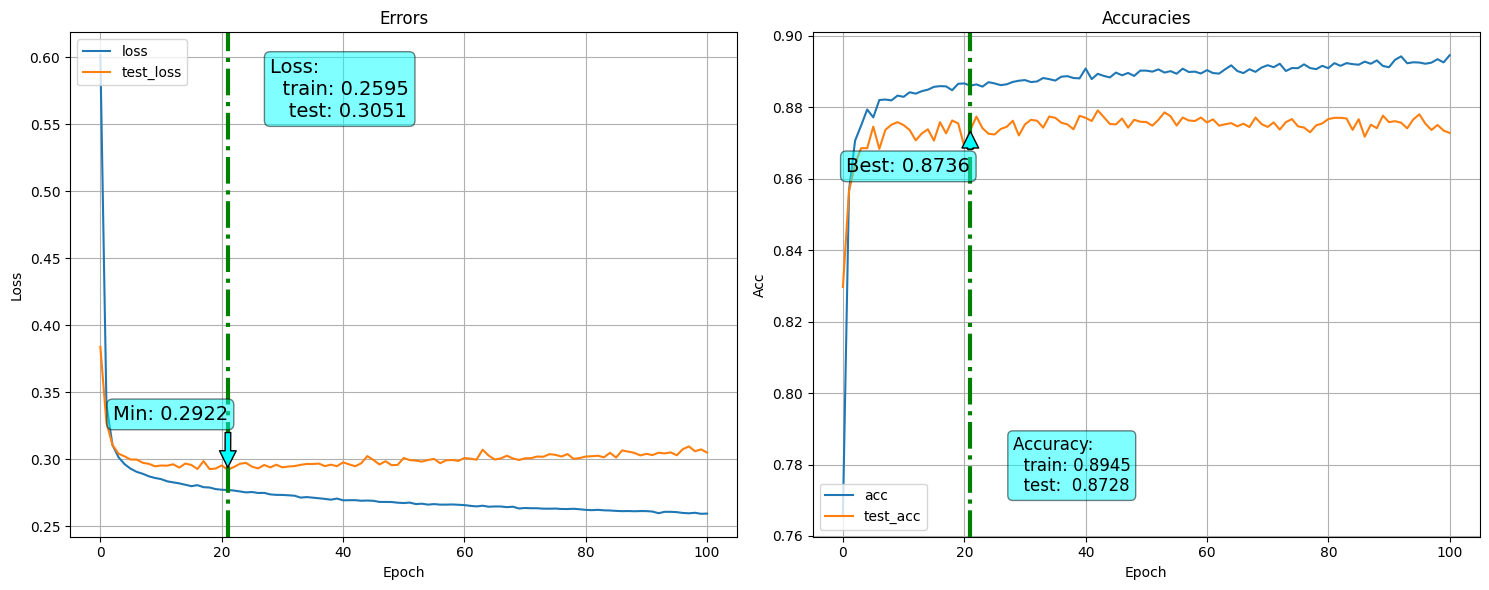

In [33]:
fn_plot_torch_hist(loss_df)

## Performance on Train Data

In [34]:
y_pred = []
y_true = []

for train_X, train_y in train_loader:

    train_X = train_X.to(device)
    
    outputs = model(train_X)

    y_pred.extend(torch.argmax(outputs, dim = 1).cpu().numpy())

    y_true.extend(train_y)

len(y_pred)

14517

In [35]:
print(classification_report(y_true, y_pred ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.92      0.94      0.93      4693
           2       0.86      0.87      0.86      5470
           3       0.85      0.82      0.83      2734

    accuracy                           0.89     14517
   macro avg       0.91      0.90      0.91     14517
weighted avg       0.89      0.89      0.89     14517



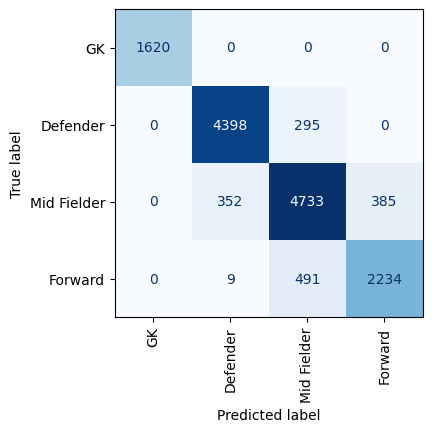

In [36]:
fn_plot_confusion_matrix(y_true, y_pred, labels=class_labels)

## Performance on test data

In [37]:
y_pred = []
y_true = []

for test_X, test_y in test_loader:

    test_X = test_X.to(device)
    
    outputs = model(test_X)

    y_pred.extend(torch.argmax(outputs, dim = 1).cpu().numpy())

    y_true.extend(test_y)


print(classification_report(y_true, y_pred ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       0.91      0.93      0.92      1173
           2       0.83      0.84      0.84      1368
           3       0.80      0.75      0.78       684

    accuracy                           0.87      3630
   macro avg       0.89      0.88      0.88      3630
weighted avg       0.87      0.87      0.87      3630



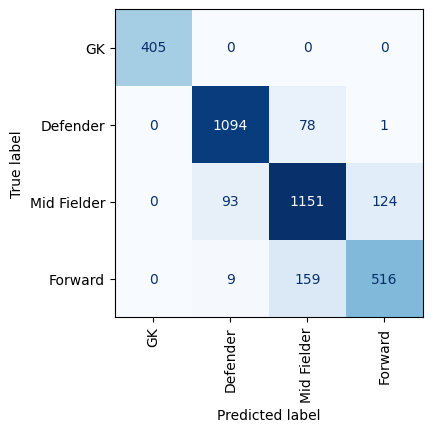

In [38]:
fn_plot_confusion_matrix(y_true, y_pred, labels=class_labels)